In [1]:
#%pip install pandas numpy matplotlib seaborn scikit-learn torch prometheus_client prometheus_api prometheus-api-client tsts

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from itertools import product

from prometheus_api_client import PrometheusConnect
from prometheus_api_client.metric_range_df import MetricRangeDataFrame
from prometheus_api_client.utils import parse_datetime

import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
#from tsts.models import Transformer
#from tsts.utils import TimeSeriesTensor

import torch
import torch.nn as nn
import torch.optim as optim

In [26]:
# Importar bibliotecas necessárias
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
import os

# Definir caminhos e constantes
DATA_DIR = "../../data/"
MB = 1_048_576  # Bytes para MB

# Carregar o dataset e realizar o resample de 5 minutos
file_path = os.path.join(DATA_DIR, 'ts.pkl')
df = pd.read_pickle(file_path)
df = df['value'].astype(float).resample('5min').mean()  # Resample para média de 5 minutos
df = df.dropna()  # Remover possíveis NaNs após o resample
dates = df.index

# Padronizar os dados
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.values.reshape(-1, 1))

# Criar sequências e associar datas aos alvos
SEQ_LENGTH = 60  # 60 intervalos de 5 minutos = 300 minutos (5 horas)
# Para manter ~60 minutos, use SEQ_LENGTH = 12 (12 * 5min = 60min)
X, y, y_dates = [], [], []
for i in range(len(df_scaled) - SEQ_LENGTH):
    X.append(df_scaled[i:i + SEQ_LENGTH])
    y.append(df_scaled[i + SEQ_LENGTH])
    y_dates.append(dates[i + SEQ_LENGTH])

X = np.array(X)
y = np.array(y)
y_dates = np.array(y_dates)

# Expandir a dimensão para corresponder a 'd_model'
d_model = 64
X = np.repeat(X, d_model, axis=2)

# Divisão sequencial (70/30, conforme o paper)
train_size = int(0.7 * len(X))  # 70% para treino
# Para 80/20, use: train_size = int(0.8 * len(X))
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]
y_dates_train = y_dates[:train_size]
y_dates_test = y_dates[train_size:]

# Determinar a data de separação (última data do treino)
train_test_split_date = y_dates_train[-1]

# Converter para tensores PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [27]:
# Define the Transformer Encoder model
class Encoder(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dim_feedforward):
        super(Encoder, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.linear_out = nn.Linear(d_model, 1)

    def forward(self, src):
        src = src.permute(1, 0, 2)
        output = self.transformer_encoder(src)
        output = self.linear_out(output[-1])
        return output

# Hyperparameters to tune
learning_rates = [0.001, 0.01]
num_layers_list = [2, 3]

# Other fixed hyperparameters
input_dim = d_model
nhead = 4
dim_feedforward = 256
batch_size = 64
num_epochs = 10

# Function to run the training loop for a given set of hyperparameters
def train_model(learning_rate, num_layers):
    # Initialize model, loss, and optimizer with the given hyperparameters
    model = Encoder(input_dim, d_model, nhead, num_layers, dim_feedforward)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]
            
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
    return model

# Initialize the best MAE and RMSE to infinity and the best hyperparameters to None
best_mae = float('inf')
best_rmse = float('inf')
best_hyperparams = None
best_model = None

# Grid search
for learning_rate, num_layers in product(learning_rates, num_layers_list):
    model = train_model(learning_rate, num_layers)
    
    # Evaluate the model
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
    
    # Rescale the predicted values
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test)
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    
    print(f'Learning Rate: {learning_rate}, Num Layers: {num_layers}, MAE: {mae}, RMSE: {rmse}')
    
    # Update the best MAE and RMSE and best hyperparameters if needed
    if mae < best_mae:
        best_mae = mae
        best_rmse = rmse
        best_hyperparams = {'learning_rate': learning_rate, 'num_layers': num_layers}
        best_model = model

print(f'Best Hyperparameters: {best_hyperparams}, Best MAE: {best_mae}, Best RMSE: {best_rmse}')


/Users/wrosalem/Documents/0x0-Coding/GitHub/dissertacao/Experiments/src/2025/.venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Learning Rate: 0.001, Num Layers: 2, MAE: 22560258.67509348, RMSE: 40102377.558026634


/Users/wrosalem/Documents/0x0-Coding/GitHub/dissertacao/Experiments/src/2025/.venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Learning Rate: 0.001, Num Layers: 3, MAE: 22364002.10648825, RMSE: 39716568.929780066


/Users/wrosalem/Documents/0x0-Coding/GitHub/dissertacao/Experiments/src/2025/.venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Learning Rate: 0.01, Num Layers: 2, MAE: 36707652.8221153, RMSE: 49133629.71152609


/Users/wrosalem/Documents/0x0-Coding/GitHub/dissertacao/Experiments/src/2025/.venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Learning Rate: 0.01, Num Layers: 3, MAE: 57522406.51987572, RMSE: 69309428.60789208
Best Hyperparameters: {'learning_rate': 0.001, 'num_layers': 3}, Best MAE: 22364002.10648825, Best RMSE: 39716568.929780066


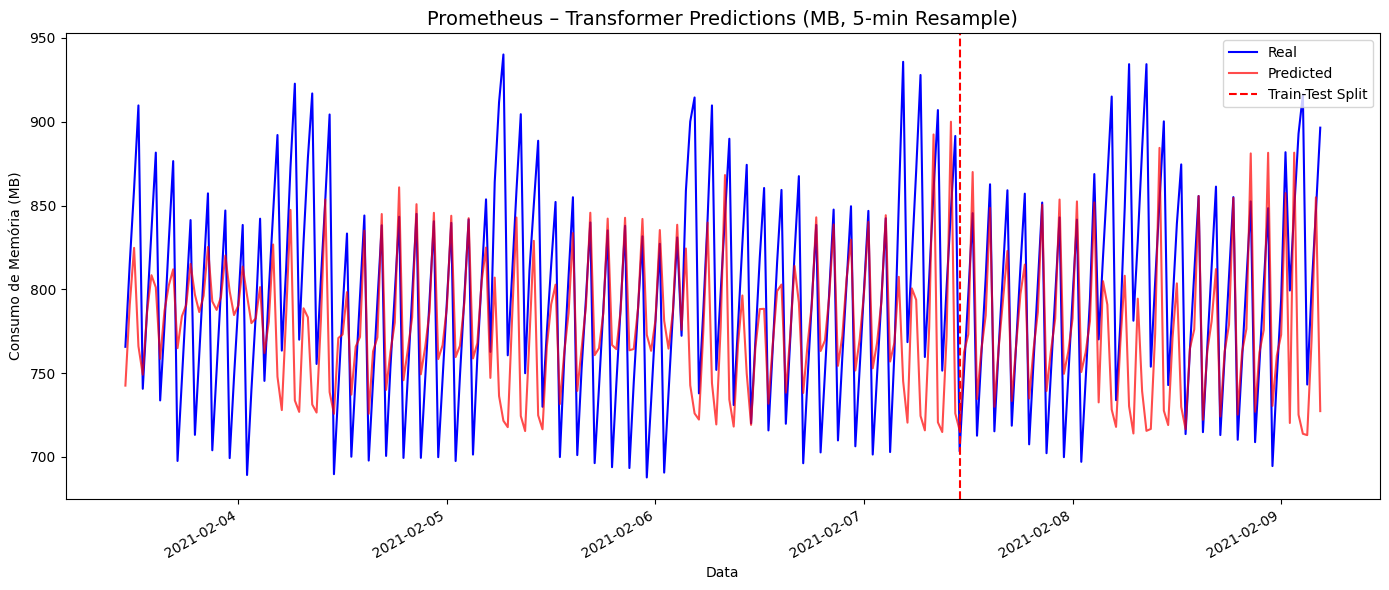

In [24]:
# Fazer previsões com o melhor modelo
model = best_model
model.eval()

# Previsões no conjunto de treino
with torch.no_grad():
    y_train_pred = model(X_train)
y_train_pred_original = scaler.inverse_transform(y_train_pred.numpy())
y_train_original = scaler.inverse_transform(y_train.numpy())

# Converter para MB
y_train_pred_mb = y_train_pred_original / MB
y_train_mb = y_train_original / MB

# Previsões no conjunto de teste
with torch.no_grad():
    y_test_pred = model(X_test)
y_test_pred_original = scaler.inverse_transform(y_test_pred.numpy())
y_test_original = scaler.inverse_transform(y_test.numpy())

y_test_pred_mb = y_test_pred_original / MB
y_test_mb = y_test_original / MB

# Criar DataFrames para ordenar por data
train_df = pd.DataFrame({
    'date': y_dates_train,
    'actual': y_train_mb.flatten(),
    'predicted': y_train_pred_mb.flatten()
})
test_df = pd.DataFrame({
    'date': y_dates_test,
    'actual': y_test_mb.flatten(),
    'predicted': y_test_pred_mb.flatten()
})

# Concatenar os DataFrames e ordenar por data
full_df = pd.concat([train_df, test_df]).sort_values('date')

# Criar um único gráfico no estilo do paper
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(full_df['date'], full_df['actual'], label="Real", color='blue')
ax.plot(full_df['date'], full_df['predicted'], label="Predicted", alpha=0.7, color='red')
ax.axvline(x=train_test_split_date, color="red", linestyle="--", label="Train-Test Split")
ax.set_title("Prometheus – Transformer Predictions (MB, 5-min Resample)", fontsize=14)
ax.set_xlabel("Data")
ax.set_ylabel("Consumo de Memória (MB)")
ax.legend()

# Formatar o eixo x
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.tick_params(axis='x', rotation=45)

# Ajustar o layout
fig.autofmt_xdate()
plt.tight_layout()

# Salvar a figura com 300 DPI
plt.savefig(os.path.join(DATA_DIR, 'prometheus_transformer_unified_5min.png'), dpi=300)
plt.show()

In [29]:
import pandas as pd
import numpy as np
import os
import torch
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Definindo constantes
DATA_DIR = "../../data/"
FILE_PATH = os.path.join(DATA_DIR, 'ts.pkl')
SEQ_LENGTH = 60
MB = 1_048_576

# 1. Carregar e reamostrar os dados
df = pd.read_pickle(FILE_PATH)
ts = df['value'].astype(float).resample('5min').mean().dropna()
dates = ts.index

# 2. Dividir os dados em treino e teste (70% treino, 30% teste)
train_size = int(0.7 * len(ts))
train = ts[:train_size]
test = ts[train_size:]

# 3. Escalonar os dados
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
test_scaled = scaler.transform(test.values.reshape(-1, 1))

# 4. Criar sequências para o modelo
X_train, y_train, y_dates_train = [], [], []
X_test, y_test, y_dates_test = [], [], []

for i in range(len(train_scaled) - SEQ_LENGTH):
    X_train.append(train_scaled[i:i + SEQ_LENGTH])
    y_train.append(train_scaled[i + SEQ_LENGTH])
    y_dates_train.append(dates[i + SEQ_LENGTH])

for i in range(len(test_scaled) - SEQ_LENGTH):
    X_test.append(test_scaled[i:i + SEQ_LENGTH])
    y_test.append(test_scaled[i + SEQ_LENGTH])
    y_dates_test.append(dates[train_size + i + SEQ_LENGTH])

X_train = np.array(X_train)
y_train = np.array(y_train)
y_dates_train = np.array(y_dates_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
y_dates_test = np.array(y_dates_test)

# 5. Ajustar dimensões para o modelo Transformer
d_model = 64
X_train = np.repeat(X_train, d_model, axis=2)
X_test = np.repeat(X_test, d_model, axis=2)

# 6. Converter para tensores PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Define the Transformer Encoder model
class Encoder(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dim_feedforward):
        super(Encoder, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.linear_out = nn.Linear(d_model, 1)

    def forward(self, src):
        src = src.permute(1, 0, 2)
        output = self.transformer_encoder(src)
        output = self.linear_out(output[-1])
        return output

# Hyperparameters to tune
learning_rates = [0.001, 0.01]
num_layers_list = [2, 3]

# Other fixed hyperparameters
input_dim = d_model
nhead = 4
dim_feedforward = 256
batch_size = 64
num_epochs = 10

# Function to run the training loop for a given set of hyperparameters
def train_model(learning_rate, num_layers):
    # Initialize model, loss, and optimizer with the given hyperparameters
    model = Encoder(input_dim, d_model, nhead, num_layers, dim_feedforward)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]
            
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
    return model

# Initialize the best MAE and RMSE to infinity and the best hyperparameters to None
best_mae = float('inf')
best_rmse = float('inf')
best_hyperparams = None
best_model = None

# Grid search
for learning_rate, num_layers in product(learning_rates, num_layers_list):
    model = train_model(learning_rate, num_layers)
    
    # Evaluate the model
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
    
    # Rescale the predicted values
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test)
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    
    print(f'Learning Rate: {learning_rate}, Num Layers: {num_layers}, MAE: {mae}, RMSE: {rmse}')
    
    # Update the best MAE and RMSE and best hyperparameters if needed
    if mae < best_mae:
        best_mae = mae
        best_rmse = rmse
        best_hyperparams = {'learning_rate': learning_rate, 'num_layers': num_layers}
        best_model = model

print(f'Best Hyperparameters: {best_hyperparams}, Best MAE: {best_mae}, Best RMSE: {best_rmse}')


# 7. Fazer previsões (assumindo que best_model é o modelo treinado)
model = best_model  # Substitua por seu modelo treinado
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train)
    y_test_pred = model(X_test)

# 8. Reverter o escalonamento e converter para MB
y_train_pred_original = scaler.inverse_transform(y_train_pred.numpy())
y_train_original = scaler.inverse_transform(y_train.numpy())
y_test_pred_original = scaler.inverse_transform(y_test_pred.numpy())
y_test_original = scaler.inverse_transform(y_test.numpy())

y_train_pred_mb = y_train_pred_original / MB
y_train_mb = y_train_original / MB
y_test_pred_mb = y_test_pred_original / MB
y_test_mb = y_test_original / MB

# 9. Preparar dados para plotagem
train_df = pd.DataFrame({
    'date': y_dates_train,
    'actual': y_train_mb.flatten(),
    'predicted': y_train_pred_mb.flatten()
}).sort_values('date')

test_df = pd.DataFrame({
    'date': y_dates_test,
    'actual': y_test_mb.flatten(),
    'predicted': y_test_pred_mb.flatten()
}).sort_values('date')

# 10. Plotar os resultados (inspirado no exemplo do link)
plt.style.use('default')
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=False)

# Plot treino
axs[0].plot(train_df['date'], train_df['actual'], label='Real', color='blue', linewidth=1.5)
axs[0].plot(train_df['date'], train_df['predicted'], label='Predito', color='red', alpha=0.7, linewidth=1.5)
axs[0].set_title('Conjunto de Treinamento (70%)', fontsize=12, pad=10)
axs[0].set_ylabel('Consumo de Memória (MB)', fontsize=10)
axs[0].legend(loc='upper left', fontsize=10)
axs[0].grid(True, linestyle='--', alpha=0.7)

# Plot teste
axs[1].plot(test_df['date'], test_df['actual'], label='Real', color='blue', linewidth=1.5)
axs[1].plot(test_df['date'], test_df['predicted'], label='Predito', color='red', alpha=0.7, linewidth=1.5)
axs[1].set_title('Conjunto de Teste (30%)', fontsize=12, pad=10)
axs[1].set_xlabel('Data', fontsize=10)
axs[1].set_ylabel('Consumo de Memória (MB)', fontsize=10)
axs[1].legend(loc='upper left', fontsize=10)
axs[1].grid(True, linestyle='--', alpha=0.7)

# Formatação dos eixos
for ax in axs:
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.tick_params(axis='x', rotation=45, labelsize=9)
    ax.tick_params(axis='y', labelsize=9)

plt.suptitle('Predições do Transformer - Prometheus (MB, Resample 30min)', fontsize=14, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(DATA_DIR, 'prometheus_transformer_30min.png'), dpi=300, bbox_inches='tight')
plt.close()

/Users/wrosalem/Documents/0x0-Coding/GitHub/dissertacao/Experiments/src/2025/.venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Learning Rate: 0.001, Num Layers: 2, MAE: 19737275.065221943, RMSE: 38416013.43616052


/Users/wrosalem/Documents/0x0-Coding/GitHub/dissertacao/Experiments/src/2025/.venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Learning Rate: 0.001, Num Layers: 3, MAE: 20017316.511103902, RMSE: 38255832.268258706


/Users/wrosalem/Documents/0x0-Coding/GitHub/dissertacao/Experiments/src/2025/.venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Learning Rate: 0.01, Num Layers: 2, MAE: 35309949.21193531, RMSE: 47938673.87241889


/Users/wrosalem/Documents/0x0-Coding/GitHub/dissertacao/Experiments/src/2025/.venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Learning Rate: 0.01, Num Layers: 3, MAE: 35447277.82091721, RMSE: 47832634.991212934
Best Hyperparameters: {'learning_rate': 0.001, 'num_layers': 2}, Best MAE: 19737275.065221943, Best RMSE: 38416013.43616052
